# Лабораторная работа №5

ФИО:   Людофа Елена
Группа: БИВТ-23-СП-1

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
#### Теперь по пунктам, что я от вас жду:

1. **Загрузить данные** к себе и считать (read) их в переменные.  

2. **Описать постановку задачи**, что от вас хотят.  
   Какие классы, бинарная или многоклассовая классификация, пример реального применения.  
   Показать по 2–3 примера изображений на класс.

3. **Сделать предобработку данных**:  
   - Проверить битые файлы/повреждённые изображения, привести к единому размеру (например, `224×224`).  
   - Нормализовать по каналам (стандарт для ImageNet: mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).  
   - Разделить на **train**/**val** (или **train**/**test**).  
   - Оформить данные в `Dataset`/`ImageFolder` и передать в `DataLoader`.

4. **Провести разведочный анализ данных (EDA)**:  
   - Посчитать количество изображений в каждом классе и оценить дисбаланс.  
   - Построить 1–2 гистограммы/барчарта распределения по классам.  
   - Сделать промежуточные выводы (есть ли редкие классы, артефакты, перекрытие классов и т.п.).

5. **Настроить аугментации** (минимум три): `RandomHorizontalFlip`, `RandomRotation`, `ColorJitter`, `RandomResizedCrop` и др.  
   Коротко описать, почему выбраны именно эти аугментации и как они помогают обобщению.

6. **Выбор и обучение модели**:  
   - Базовый вариант: **transfer learning** на `ResNet18`/`MobileNetV2`/`EfficientNetB0` (предобученные веса).  
   - Заменить выходной слой под число классов.  
   - Задать функцию потерь `CrossEntropyLoss`, оптимизатор (`AdamW`/`SGD`) и расписание обучения (кол-во эпох, `lr`).  
   - В процессе обучения логировать `train loss/acc` и `val loss/acc` по эпохам.  
   - Сохранить лучшую модель по `val acc`/минимальному `val loss`.

7. **Посчитать метрики качества** на **train** и **val/test** множествах:  
   - Для классификации: `Accuracy`, `Precision`, `Recall`, `F1` (macro/micro — обосновать выбор).  
   - Построить **матрицу ошибок (Confusion Matrix)**; ROC-кривые.

8. **Сравнить результаты** (если пробовали несколько моделей/настроек):  
   - Какая модель лучше справилась?  
   - Есть ли переобучение (по кривым обучения)?  
   - Какие классы путаются чаще всего и почему?  
   - Что ещё можно улучшить (аугментации, веса классов, больше данных, регуляризация, тонкая настройка `lr` и т.д.)?

9. **Визуализировать предсказания**:  
   - Показать не менее 10 изображений из валидации/теста с предсказанными и истинными классами.  
   - Пометить корректные (`Y`) и ошибочные (`N`) предсказания, сделать краткие выводы.

---

## P.S.
Просьба — делать каждое задание в отдельных ячейках с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа:
- Заголовок  
- Ячейка с кодом  
- Другой заголовок  
- Другая ячейка с кодом

## P.S.S.
Если у вас **многоклассовая** классификация, убедитесь, что последний слой имеет размерность `num_classes`, а для `CrossEntropyLoss` **не** требуется one-hot.  
При сильном дисбалансе рассмотрите: `class weights` в `CrossEntropyLoss`, oversampling/undersampling.


## 1. Пример импорта данных. Грузим данные

In [116]:
import os
from PIL import Image
data_dir = "train"
classes = sorted(os.listdir(data_dir))
labels2id = {classes[i]:i for i in range(len(classes))}
id2labels = {labels2id[i]:i for i in labels2id.keys()}

def load_pairs(dir):
    pairs = []
    for i in classes:
        for path in os.listdir(os.path.join(dir, i)):
            pairs.append([os.path.join(dir, i, path), labels2id[i]])
    return pairs

train_data = load_pairs(data_dir)
val_data = load_pairs("valid")
test_data = load_pairs("test")

## 2. Понимаем, какая перед нами задача

air hockey


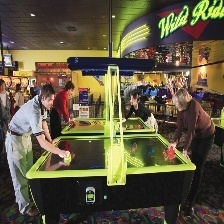

In [117]:
ind = 0
print(id2labels[train_data[ind][1]])
Image.open(train_data[ind][0])

wingsuit flying


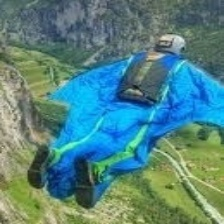

In [118]:
ind = -1
print(id2labels[train_data[ind][1]])
Image.open(train_data[ind][0])

In [119]:
'''
многоклассовая классификация
'''

'\nмногоклассовая классификация\n'

## 3. Делаем предобработку данных

In [120]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, data, img_size=224, train=False):
        self.data = data
        if train:
            self.base_transforms = transforms.Compose([
                    transforms.Resize((img_size, img_size)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=15),
                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ])
        else:
            self.base_transforms = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.base_transforms(Image.open(self.data[idx][0]).convert('RGB'))
        return image, self.data[idx][1]

In [121]:
train_dataset = ImageDataset(train_data, 224, train=True)
val_dataset = ImageDataset(val_data, 224, train=True)
test_dataset = ImageDataset(test_data, 224, train=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                          num_workers=0)
val_loader = DataLoader(val_dataset,   batch_size=8, shuffle=False,
                          num_workers=0)
test_loader = DataLoader(test_dataset,   batch_size=4, shuffle=False,
                          num_workers=0)

## 4. Провести разведочный анализ данных (EDA)

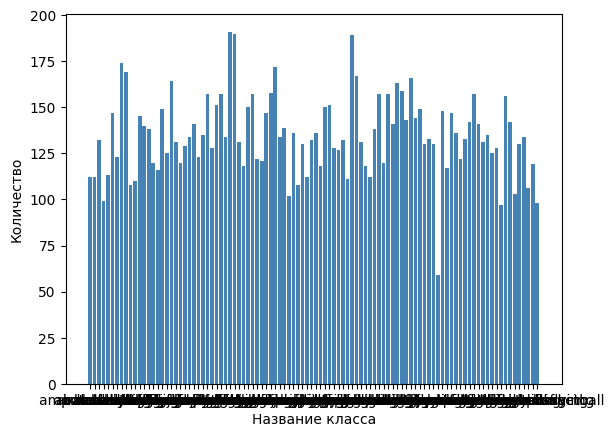

In [122]:
from collections import Counter
import matplotlib.pyplot as plt
classes_counter = dict(Counter([id2labels[i[1]] for i in train_data]))
categories =[i for i in classes_counter.keys()]
values = [classes_counter[i] for i in classes_counter.keys()]
plt.bar(categories, values, color='steelblue')

plt.xlabel('Название класса')
plt.ylabel('Количество')

plt.show()

## 6. Ставим обучение

In [123]:
from torchvision import models
import torch.optim as optim
from tqdm.auto import tqdm

In [124]:
device = 'cuda'

In [125]:
def get_model(model_name: str, num_classes: int):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model.to(device)

In [159]:
# MODEL_NAME = "mobilenet_v2"
# MODEL_NAME = "efficientnet_b0"
MODEL_NAME = "resnet18"
model = get_model(MODEL_NAME, len(labels2id))

criterion = nn.CrossEntropyLoss()

In [160]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [161]:
len(val_loader.dataset)

500

In [162]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):

    best_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch in tqdm(dataloaders[phase]):
                inputs = batch[0].to(device)
                labels = batch[1].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), f"best_model_{MODEL_NAME}.pth")
                print(f"New best model saved with val acc: {best_acc:.4f}")
            torch.save(model.state_dict(), f"best_model_{MODEL_NAME}.pth")


        print()

    print(f'Best val Acc: {best_acc:.4f}')

    return model, history

In [163]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model_trained, history = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=5
)

Epoch 1/5
----------


  0%|          | 0/1687 [00:00<?, ?it/s]

train Loss: 3.9941 Acc: 0.0793


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 3.1348 Acc: 0.1760
New best model saved with val acc: 0.1760

Epoch 2/5
----------


  0%|          | 0/1687 [00:00<?, ?it/s]

train Loss: 3.0814 Acc: 0.2126


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 2.4398 Acc: 0.3500
New best model saved with val acc: 0.3500

Epoch 3/5
----------


  0%|          | 0/1687 [00:00<?, ?it/s]

train Loss: 2.4436 Acc: 0.3457


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 1.8275 Acc: 0.4960
New best model saved with val acc: 0.4960

Epoch 4/5
----------


  0%|          | 0/1687 [00:00<?, ?it/s]

train Loss: 1.9988 Acc: 0.4551


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 1.4427 Acc: 0.5760
New best model saved with val acc: 0.5760

Epoch 5/5
----------


  0%|          | 0/1687 [00:00<?, ?it/s]

train Loss: 1.6814 Acc: 0.5355


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 1.2847 Acc: 0.6220
New best model saved with val acc: 0.6220

Best val Acc: 0.6220


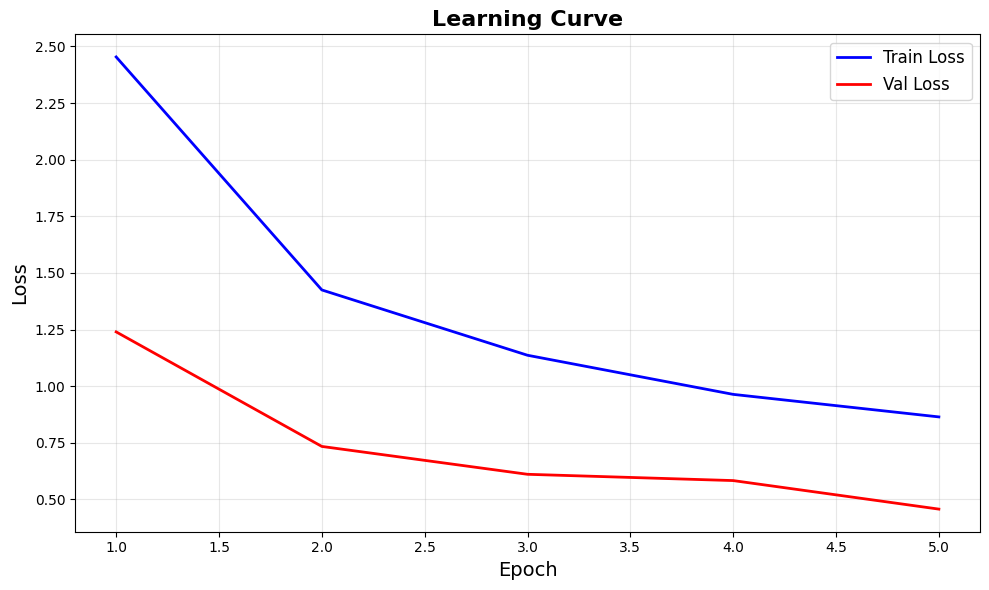

In [131]:
#mobilenet_v2
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
epochs = range(1, len(history['train_loss']) + 1)


plt.plot(epochs, history['train_loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, history['val_loss'],  label='Val Loss',  linewidth=2, color='red')

plt.title('Learning Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

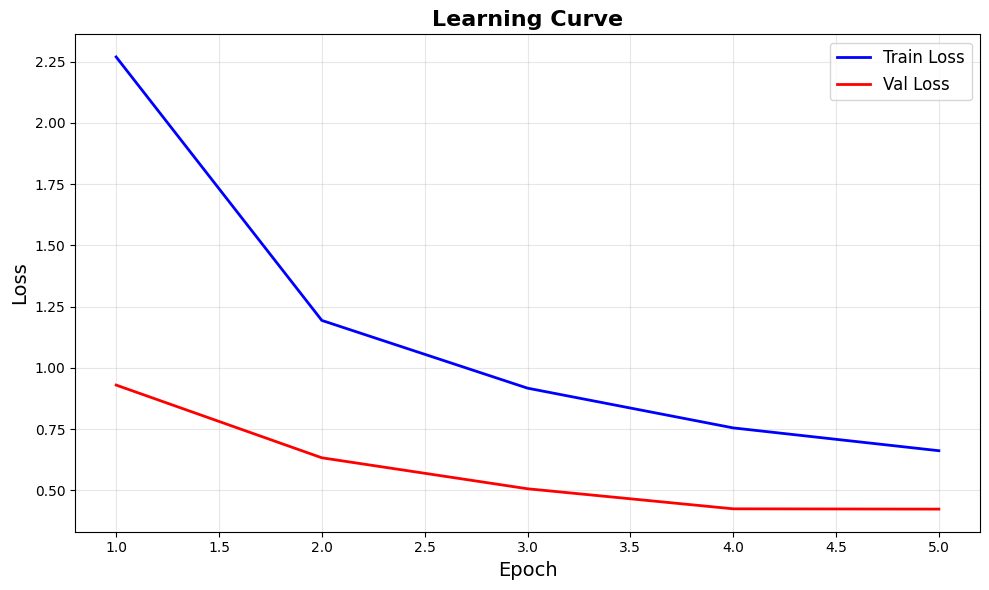

In [158]:
#efficientnet_b0
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, history['val_loss'],  label='Val Loss',  linewidth=2, color='red')

plt.title('Learning Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

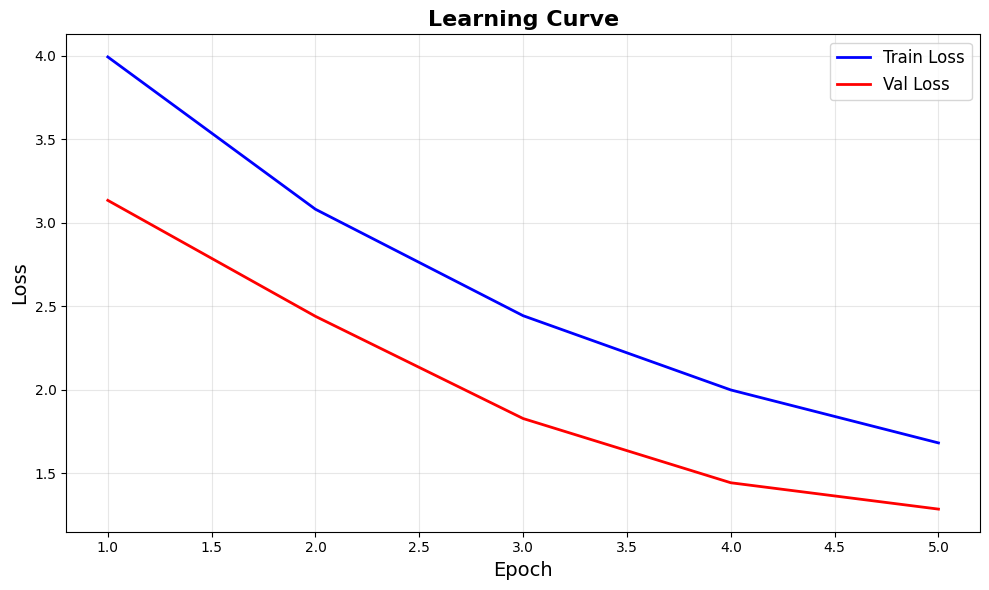

In [164]:
#resnet
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], label='Train Loss', linewidth=2, color='blue')
plt.plot(epochs, history['val_loss'],  label='Val Loss',  linewidth=2, color='red')

plt.title('Learning Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

In [135]:
def evaluate_dataset(model, dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_labels, all_preds, all_probs

In [136]:
def print_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (micro):    {recall_micro:.4f}")
    print(f"F1 (micro):        {f1_micro:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro):    {recall_macro:.4f}")
    print(f"F1 (macro):        {f1_macro:.4f}")


In [138]:
# MODEL_NAME = "efficientnet_b0"
# MODEL_NAME = "resnet18"
MODEL_NAME = "mobilenet_v2"

model = get_model(MODEL_NAME, len(labels2id))
model.load_state_dict(torch.load('/content/best_model_mobilenet_v2.pth'))
model.eval()
None

In [139]:
#resnet
test_labels, test_preds, test_probs = evaluate_dataset(model, test_loader)
print_metrics(test_labels, test_preds)

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.8720
Precision (micro): 0.8720
Recall (micro):    0.8720
F1 (micro):        0.8720
Precision (macro): 0.8835
Recall (macro):    0.8720
F1 (macro):        0.8640


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
#efficientnet_b0
test_labels, test_preds, test_probs = evaluate_dataset(model, test_loader)
print_metrics(test_labels, test_preds)

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.8820
Precision (micro): 0.8820
Recall (micro):    0.8820
F1 (micro):        0.8820
Precision (macro): 0.9081
Recall (macro):    0.8820
F1 (macro):        0.8775


In [141]:
#mobilenet_v2
test_labels, test_preds, test_probs = evaluate_dataset(model, test_loader)
print_metrics(test_labels, test_preds)

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.8660
Precision (micro): 0.8660
Recall (micro):    0.8660
F1 (micro):        0.8660
Precision (macro): 0.8989
Recall (macro):    0.8660
F1 (macro):        0.8579


In [142]:
base_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ])

def pred_model(img, model):
    image = base_transforms(img.convert('RGB')).unsqueeze(0).to(device)
    outputs = model(image)
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    preds = preds[0].item()
    return id2labels[preds]

prediction bike polo
true bike polo


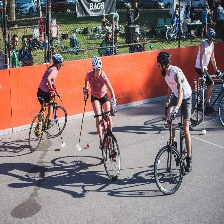

In [143]:
ind = 50
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction chuckwagon racing
true chuckwagon racing


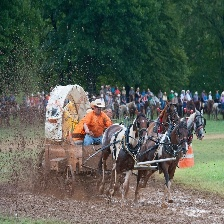

In [144]:
ind = 100
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction fly fishing
true fly fishing


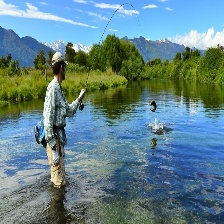

In [145]:
ind = 150
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction high jump
true high jump


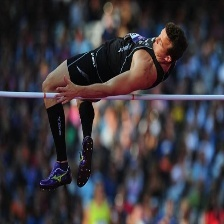

In [146]:
ind = 200
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction javelin
true javelin


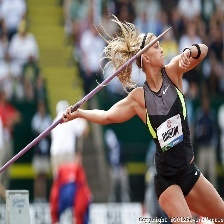

In [147]:
ind = 250
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction parallel bar
true parallel bar


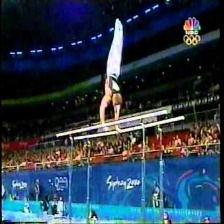

In [148]:
ind = 300
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction rowing
true rowing


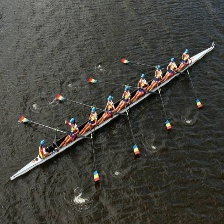

In [149]:
ind = 350
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction bobsled
true snowmobile racing


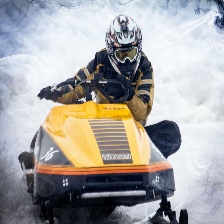

In [150]:
ind = 400
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction tug of war
true tug of war


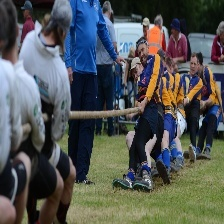

In [151]:
ind = 450
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])

prediction rings
true rings


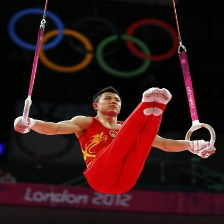

In [152]:
ind = 330
print('prediction', pred_model(Image.open(test_data[ind][0]), model))
print('true', id2labels[test_data[ind][1]])
Image.open(test_data[ind][0])